# Optimal control course project
# Solving the CartPole-v1 problem

by **Artem Petrov** and **Ivan Kudriakov**

Solving CartPole-v1 from openai.gym using methods of the Optimal Control Theory


# Step 1 
### (March 9, 2022)

## Mathematical model

The environment simulation of CartPole-v1 is performed according to the model, described here: https://coneural.org/florian/papers/05_cart_pole.pdf

([Proof from the code of CartPole-v1](https://github.com/openai/gym/blob/2dddaf722acccfd0412d745890c40dcd972586d5/gym/envs/classic_control/cartpole.py#L126))

Here, I will provide the brief explanation of the model

<img src="presentation_media/forces_model.png" alt="drawing" width="500"/>

<!-- Here $G_c$ and $G_p$ are the forces of gravity acting on cart and pole respectively.

Here $N_c$ - reaction force and $F_f$ - friction force between the cart and the rail -->

Original model considers the friction forces, however in CartPole-v1 there are no friction.

<!-- 
$\mu_c$ - friction coefficient between the cart and the rail

$\mu_p$ - friction coefficient between the cart and the pole

Side note: the initial model assumes Lubricated friction between the pole and the cart which is somewhat counterintuitive. -->

From the frictionless Newton equations the following  movement equations can be derived:

$$
\ddot{\theta} = \frac{g \sin \theta + \cos \theta \left( \frac{- F - m_p l \dot{\theta}^2\sin \theta}{m_c + m_p} \right)}
{l\left(\frac{4}{3} - \frac{m_p \cos ^2 \theta}{m_c + m_p}\right)}
\label{eq:theta} \tag{1}
$$

$$
\ddot{x} = \frac{F + m_p l\left(\dot{\theta}^2 \sin \theta - \ddot{\theta}\cos\theta\right)}
{m_c + m_p}
\label{eq:x} \tag{2}
$$

Where:

$m_c$ - the mass of the cart 

$m_p$ - the mass of the pole 

$l$ - half-length of the pole

$F = \pm F_0$ - horizontal force applied to the cart by the agent.

Interested reader who want to check out the whole inference of the equations above may want to read [the original source](https://coneural.org/florian/papers/05_cart_pole.pdf)


#### Now, let's pose the problem in terms of the optimal control theory.

The goal is to keep the pole upright for the longest time. 

Hence, one might suggests the usage of one the following simple functionals:

$$ 
\left[
\begin{array}[lll]
    .
    J_{\text{1}} = \int\limits_{0}^{\infty} \theta^2 dt \rightarrow \min \\
    J_{\text{2}} = \int\limits_{0}^{T} \theta^2 dt \rightarrow \min \\
    J_{\text{3}} = \int\limits_{0}^{T} |\theta| dt \rightarrow \min
\end{array}
\right .
$$ 


However, if we want to optimize for the highest value of the agent's reward function, the following functional must be used:

$$ J = T \rightarrow \max \tag{3} $$




Let $\mathbf{q} = (x, \dot{x}, \theta, \dot{\theta})^T$

$F = u F_0$, where $u \in \{-1, +1\}$ - control

Then, the dynamic constaraints can be written as follows:

$$\mathbf{\dot{q}} = 
\begin{bmatrix}
    \dot{x} \\
    \ddot{x} \\
    \dot{\theta} \\
    \ddot{\theta}
\end{bmatrix} = 
\begin{bmatrix}
    \dot{x} \\
    \frac{F + m_p l\left(\dot{\theta}^2 \sin \theta - \ddot{\theta}\cos\theta\right)}{m_c + m_p} \\
    \dot{\theta} \\
    \frac{g \sin \theta + \cos \theta \left( \frac{- F - m_p l \dot{\theta}^2\sin \theta}{m_c + m_p} \right)}
{l\left(\frac{4}{3} - \frac{m_p \cos ^2 \theta}{m_c + m_p}\right)}
\end{bmatrix} = 
\begin{bmatrix}
    \dot{x} \\
    \frac{uF_0 + m_p l\left(\dot{\theta}^2 \sin \theta - \frac{g \sin \theta + \cos \theta \left( \frac{- uF_0 - m_p l \dot{\theta}^2\sin \theta}{m_c + m_p} \right)}
{l\left(\frac{4}{3} - \frac{m_p \cos ^2 \theta}{m_c + m_p}\right)}\cos\theta\right)}{m_c + m_p} \\
    \dot{\theta} \\
    \frac{g \sin \theta + \cos \theta \left( \frac{- u F_0 - m_p l \dot{\theta}^2\sin \theta}{m_c + m_p} \right)}
{l\left(\frac{4}{3} - \frac{m_p \cos ^2 \theta}{m_c + m_p}\right)}
\end{bmatrix} = 
\mathbf{f}(\mathbf{q}, u)$$



Also, we must consider the fact, that in this particular implementation, the simulation will stop if one of the following conditions is reached:

- $|\theta| > 12^\circ$  (which contradicts the [frontpage](https://gym.openai.com/envs/CartPole-v1/), but is consistent with the [actual code](https://github.com/openai/gym/blob/2dddaf722acccfd0412d745890c40dcd972586d5/gym/envs/classic_control/cartpole.py#L90))

- $|x| > 2.4$

- $ t \le 500\tau$, where $\tau = 0.02$sec - is the length of one episode of simulation

These conditions can be formulated as the path constraints:

$$
\begin{cases}
    |q_1| = |x| \le 2.4\\
    |q_3| = |\theta| \le 12^\circ \\
    t \le 500\tau
\end{cases} \tag{4}
$$

However, because we maximize the time when our trajectory stays within the boundaries of 
$\begin{cases}
    |q_1| = |x| \le 2.4\\
    |q_3| = |\theta| \le 12^\circ
\end{cases}$, the last condition in (4) can be dropped, as the subtrajectory $\{\mathbf{q}(t)| t \in [0,500\tau]\}$ of a valid trajectory  $\{\mathbf{q}(t) | t \in [0,T]; T>500\tau\}$ will be the optimal solution for this problem/

#### Parameters of the environment

In order to get the model's parameters one can look at [the source code](https://github.com/openai/gym/blob/2dddaf722acccfd0412d745890c40dcd972586d5/gym/envs/classic_control/cartpole.py#L80) of the CartPole-v1 environment.

$g = 9.8$

$m_c = 1.0$ 

$m_p = 0.1$

$l = 0.5$ 

$F_0 = 10.0$


# Step 2
### (March 16 2022)

# LQR solution

## What is LQR (Linear–quadratic regulator)?

### Reference information (by [Ru Wiki LQR](https://ru.wikipedia.org/wiki/%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%BE-%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82%D0%B8%D1%87%D0%BD%D1%8B%D0%B9_%D1%80%D0%B5%D0%B3%D1%83%D0%BB%D1%8F%D1%82%D0%BE%D1%80), [En Wiki LQR](https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator))

If 
$$\dot{x} = A(t)x + B(t)u$$ 
and 
$$J = \int\limits_{0}^\infty \left( x^T Q(t) x + u^T R(t) u \right) dt$$ 
then optimal control is 
$$u = -R^{-1} B^T P x$$ 
when $P$ is solution of Ricatti equation: 
$$A^T P + P A - P B R^{-1} B^T P + Q = -\dot{P}$$

### At the last seminar we found:

$$\mathbf{\dot{q}} = 
\begin{bmatrix}
    \dot{x} \\
    \ddot{x} \\
    \dot{\theta} \\
    \ddot{\theta}
\end{bmatrix} = 
\begin{bmatrix}
    \dot{x} \\
    \frac{F + m_p l\left(\dot{\theta}^2 \sin \theta - \ddot{\theta}\cos\theta\right)}{m_c + m_p} \\
    \dot{\theta} \\
    \frac{g \sin \theta + \cos \theta \left( \frac{- F - m_p l \dot{\theta}^2\sin \theta}{m_c + m_p} \right)}
{l\left(\frac{4}{3} - \frac{m_p \cos ^2 \theta}{m_c + m_p}\right)}
\end{bmatrix} = 
\begin{bmatrix}
    \dot{x} \\
    \frac{uF_0 + m_p l\left(\dot{\theta}^2 \sin \theta - \frac{g \sin \theta + \cos \theta \left( \frac{- uF_0 - m_p l \dot{\theta}^2\sin \theta}{m_c + m_p} \right)}
{l\left(\frac{4}{3} - \frac{m_p \cos ^2 \theta}{m_c + m_p}\right)}\cos\theta\right)}{m_c + m_p} \\
    \dot{\theta} \\
    \frac{g \sin \theta + \cos \theta \left( \frac{- u F_0 - m_p l \dot{\theta}^2\sin \theta}{m_c + m_p} \right)}
{l\left(\frac{4}{3} - \frac{m_p \cos ^2 \theta}{m_c + m_p}\right)}
\end{bmatrix} = 
\mathbf{f}(\mathbf{q}, u)$$

### Linearization around the upper equilibrium of our system:
$$\mathbf{\dot{q}} = 
\begin{bmatrix}
    \dot{x} \\
    \ddot{x} \\
    \dot{\theta} \\
    \ddot{\theta}
\end{bmatrix} = 
\begin{bmatrix}
    0 & 1 & 0 & 0 \\
    0 & 0 & \frac{g}{l(\frac{4}{3} - \frac{m_p}{m_p+m_c})} & 0 \\
    0 & 0 & 0 & 1 \\
    0 & 0 & \frac{g}{l(\frac{4}{3} - \frac{m_p}{m_p+m_c})} & 0 
\end{bmatrix}q + 
\begin{bmatrix}
    0 \\
    \frac{1}{m_p+m_c} \\
    0 \\
    -\frac{1}{l(\frac{4}{3} - \frac{m_p}{m_p+m_c})}
\end{bmatrix}u $$


$$\mathbf{\dot{q}} = A\mathbf{q}+B\mathbf{u}$$

$$J = \int\limits_{0}^\infty \left( q^T Q q + u^T R u \right) dt$$

$$\mathbf{u} = K \mathbf{q} =  -R^{-1} B^T P \mathbf{q}$$
#### It means, in LQR control $\mathbf{u}$ is linear function of $\mathbf{q}$, but in inital problem it is discrete
But if you look at the formula, you can see that when constrained to the maximum force, the parameter $R$ conditions the proximity of the selection function $\mathbf{u}$ to $sign$.

#### Code below refers to [Optimal Control with OpenAI Gym](https://towardsdatascience.com/comparing-optimal-control-and-reinforcement-learning-using-the-cart-pole-swing-up-openai-gym-772636bc48f4)

In [1]:
import numpy as np

g = 9.8
lp = 0.5
mp = 0.1
mc = 1.0
mt = mp + mc # m_total


# state matrix
a = g/(lp*(4.0/3 - mp/mt))
A = np.array([[0, 1, 0, 0],
              [0, 0, a, 0],
              [0, 0, 0, 1],
              [0, 0, a, 0]])

# input matrix
b = -1/(lp*(4.0/3 - mp/mt))
B = np.array([[0], [1/mt], [0], [b]])

In [2]:
R = np.eye(1, dtype=int)          # choose R (weight for input)
print('R =', R)
Q = 5*np.eye(4, dtype=int)        # choose Q (weight for state)
print('Q =\n', Q)

# get riccati solver
from scipy import linalg

# solve ricatti equation
P = linalg.solve_continuous_are(A, B, Q, R)

# calculate optimal controller gain
K = np.dot(np.linalg.inv(R),
           np.dot(B.T, P))

R = [[1]]
Q =
 [[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


In [3]:
def apply_state_controller(K, x):
    # feedback controller
    u = -np.dot(K, x)   # u = -Kx
    if u > 0:
        return 1, u     # if force_dem > 0 -> move cart right
    else:
        return 0, u     # if force_dem <= 0 -> move cart left

### In code below absolute value of force is changing on every step

In [9]:
import gym
# get environment
env = gym.make('CartPole-v0')
obs = env.reset()

for i in range(500):
    env.render()
    
    # get force direction (action) and force value (force)
    action, force = apply_state_controller(K, obs)
    
    # absolute value, since 'action' determines the sign, F_min = -10N, F_max = 10N
    abs_force = abs(float(np.clip(force, -10, 10)))
    
    # change magnitute of the applied force in CartPole
    env.env.force_mag = abs_force

    # apply action
    obs, reward, done, _ = env.step(action)
    if done:
        print(f'Terminated after {i+1} iterations.')
        break
env.close()

Terminated after 200 iterations.


### Initially absolute value of force should be constant, so lets test LQR result with constant force

In [10]:
import gym
# get environment
env = gym.make('CartPole-v0')
obs = env.reset()

for i in range(500):
    env.render()
    
    # get force direction (action) and force value (force)
    action, force = apply_state_controller(K, obs)
    
    # absolute value, since 'action' determines the sign, F_min = -10N, F_max = 10N
    abs_force = abs(float(np.clip(force, -10, 10)))
    
    # change magnitute of the applied force in CartPole
    #env.env.force_mag = abs_force

    # apply action
    obs, reward, done, _ = env.step(action)
    if done:
        print(f'Terminated after {i+1} iterations.')
        break
env.close()

Terminated after 200 iterations.


# PID (proportional–integral–derivative controller)
#### Reference by Wiki ([EN](https://en.wikipedia.org/wiki/PID_controller), [RU](https://ru.wikipedia.org/wiki/%D0%9F%D0%98%D0%94-%D1%80%D0%B5%D0%B3%D1%83%D0%BB%D1%8F%D1%82%D0%BE%D1%80))

A proportional–integral–derivative controller (PID controller or three-term controller) is a control loop mechanism employing feedback that is widely used in industrial control systems and a variety of other applications requiring continuously modulated control. A PID controller continuously calculates an error value $e(t)$ as the difference between a desired setpoint (SP) and a measured process variable (PV) and applies a correction based on proportional, integral, and derivative terms (denoted P, I, and D respectively), hence the name.


$$u(t) = K_\text{p} e(t) + K_\text{i} \int_0^t e(\tau) \,\mathrm{d}\tau + K_\text{d} \frac{\mathrm{d}e(t)}{\mathrm{d}t}$$

#### Cart-Pole problem
Target value is $\theta=0$
$$u(t) = P\theta + I\int \theta + D \dot{\theta}$$

In our model we use sign of original control

In [11]:
import numpy as np
import gym

env = gym.make('CartPole-v1')

P, I, D = 1, 1, 1
tau = 0.02

for i_episode in range(5):
    state = env.reset()
    integral = 0
    derivative = 0
    prev_error = 0
    for t in range(500):
        env.render()
        integral += state[2] * tau
        derivative = state[3]
        error = state[2]
        res = I * integral + D * derivative + P * error
        if res>0:
            action = 1
        else:
            action = 0

        state, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps


In [12]:
import numpy as np
import gym

env = gym.make('CartPole-v1')

P, I, D = 1, 0, 1
tau = 0.02

for i_episode in range(5):
    state = env.reset()
    integral = 0
    derivative = 0
    prev_error = 0
    for t in range(500):
        env.render()
        integral += state[2] * tau
        derivative = state[3]
        error = state[2]
        res = I * integral + D * derivative + P * error
        if res>0:
            action = 1
        else:
            action = 0

        state, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps


### Conclusion
Maybe this way can lead us to a good result, but it requires the selection of coefficients. These coefficients I tried are not bad, but there is often drift in the x-coordinate

### Optimization of cofficients

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym

env = gym.make('CartPole-v1')

In [35]:
def PID_opt_fun(P, I, D):
    tau = 0.02
    N = 0 # number of attempt
    x = []
    theta = []
    state = env.reset()
    integral = 0
    derivative = 0
    prev_error = 0
    for t in range(500):
        env.render()
        x.append(state[0])
        theta.append(state[2])
        if (N == 0 and abs(state[0]) > 0.5):
            N = t
            break
        integral += state[2] * tau
        derivative = state[3]
        error = state[2]
        res = I * integral + D * derivative + P * error
        
        abs_force = abs(float(np.clip(res, -10, 10)))
    
        # change magnitute of the applied force in CartPole
        env.env.force_mag = abs_force
        if res>0:
            action = 1
        else:
            action = 0

        state, reward, done, info = env.step(action)
        if done:
            #print("Episode finished after {} timesteps".format(t+1))
            break
    return x, theta, N

In [107]:
def plot_result(x, theta, N):
    B = 500
    plt.plot(range(min(len(x), B)), x[:min(len(x), B)], label= "x")
    plt.plot(range(min(len(theta), B)), theta[:min(len(theta), B)], label= "theta")
    #plt.plot(timestamp, aver, label= "Average, mcs")
    #plt.plot(timestamp, disp, label= "Dispercy, ?")
    plt.grid(True)
    plt.legend()
    #plt.axis([timestamp[0], timestamp[-1], 0, max([max(aver), max(clients), max(diff)])*1.1])
    #plt.ylabel("Request processing time, mcs")
    plt.xlabel("Timestamp")
    plt.title("PID")

    #plt.savefig("plot.png", fmt= "png")
    plt.show()


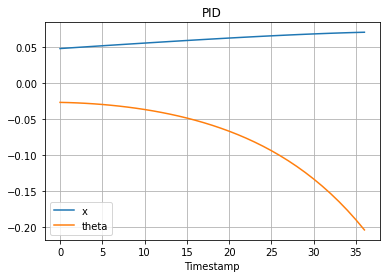

In [37]:
x, theta, N = PID_opt_fun(1, 0.002, 0.064)
plot_result(x, theta, N)

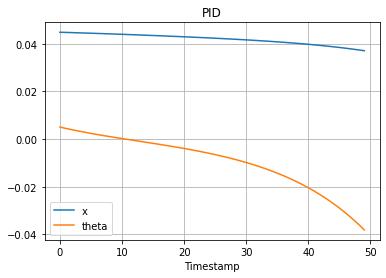

In [38]:
x, theta, N = PID_opt_fun(1, 2.0, 0.25)
plot_result(x, theta, N)

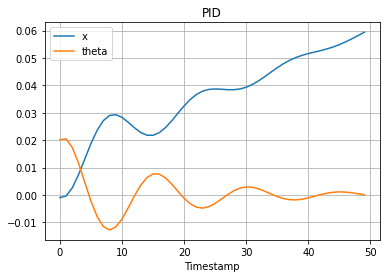

In [44]:
x, theta, N = PID_opt_fun(300, 1, 10)
plot_result(x, theta, N)

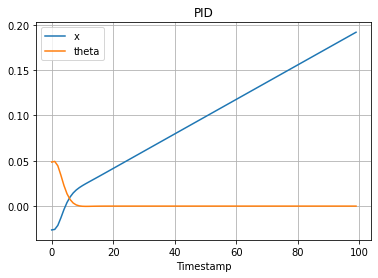

In [73]:
x, theta, N = PID_opt_fun(400, 1, 30)
plot_result(x, theta, N)

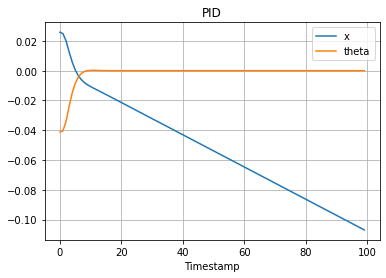

In [74]:
x, theta, N = PID_opt_fun(400, 0, 30)
plot_result(x, theta, N)

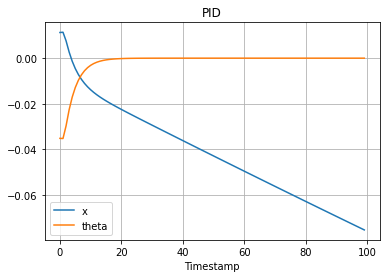

In [80]:
x, theta, N = PID_opt_fun(400, 10, 40)
plot_result(x, theta, N)

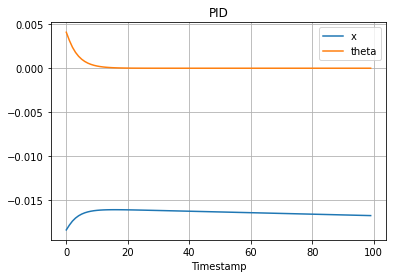

In [81]:
x, theta, N = PID_opt_fun(400, 1, 40)
plot_result(x, theta, N)

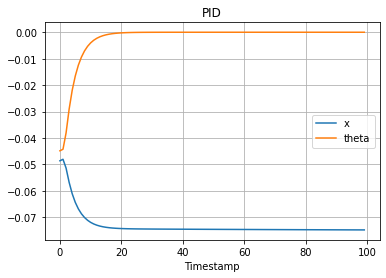

In [82]:
x, theta, N = PID_opt_fun(400, 0.5, 40)
plot_result(x, theta, N)

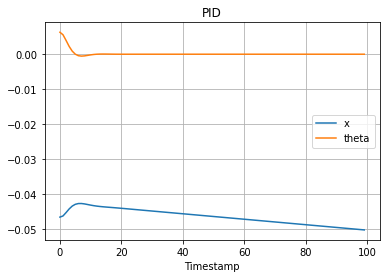

In [91]:
x, theta, N = PID_opt_fun(400, 0.5, 25)
plot_result(x, theta, N)

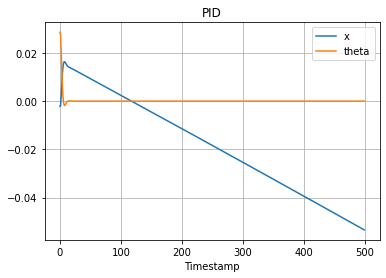

In [140]:
x, theta, N = PID_opt_fun(400, 0.5, 26)
plot_result(x, theta, N)

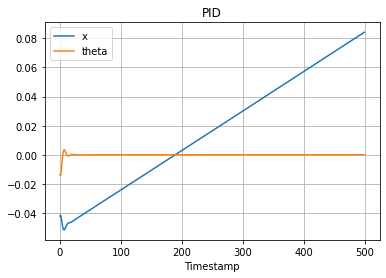

In [142]:
x, theta, N = PID_opt_fun(400, 0.5, 20)
plot_result(x, theta, N)

In [144]:
def PID_opt_fun_withX(P, I, D, pp, ii, dd):
    tau = 0.02
    N = 0 # number of attempt
    x = []
    theta = []
    state = env.reset()
    integral = 0
    derivative = 0
    prev_error = 0
    for t in range(500):
        env.render()
        x.append(state[0])
        theta.append(state[2])
        if (N == 0 and abs(state[0]) > 0.5):
            N = t
            break
        integral += state[2] * tau + state[0]*ii
        derivative = state[3] + state[1]*dd
        error = state[2] + state[0]*pp
        res = I * integral + D * derivative + P * error
        
        abs_force = abs(float(np.clip(res, -10, 10)))
    
        # change magnitute of the applied force in CartPole
        env.env.force_mag = abs_force
        if res>0:
            action = 1
        else:
            action = 0

        state, reward, done, info = env.step(action)
        if done:
            #print("Episode finished after {} timesteps".format(t+1))
            break
    return x, theta, N

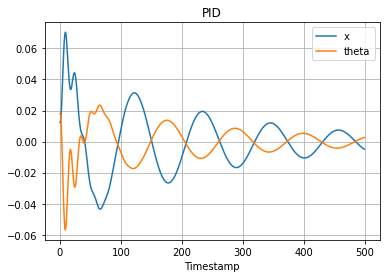

In [150]:
x, theta, N = PID_opt_fun_withX(400, 0.5, 26, 0.5, 1, 1)
plot_result(x, theta, N)

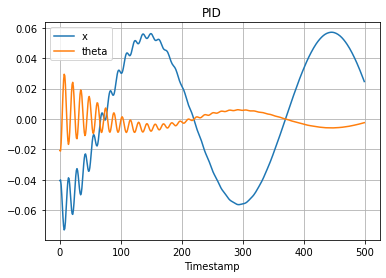

In [151]:
x, theta, N = PID_opt_fun_withX(400, 0.5, 26, 0.1, 1, 1)
plot_result(x, theta, N)

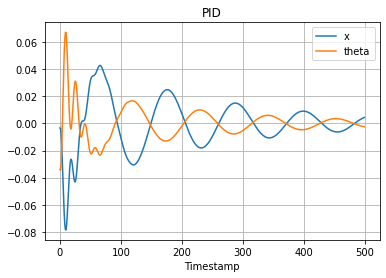

In [154]:
x, theta, N = PID_opt_fun_withX(400, 0.4, 26, 0.5, 1, 1)
plot_result(x, theta, N)

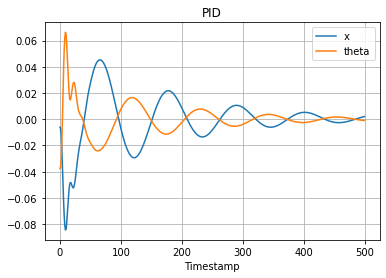

In [156]:
x, theta, N = PID_opt_fun_withX(500, 0.4, 40, 0.5, 1, 1)
plot_result(x, theta, N)

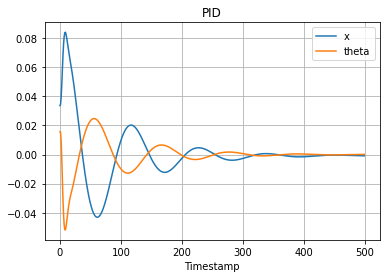

In [157]:
x, theta, N = PID_opt_fun_withX(500, 0.4, 60, 0.5, 1, 1)
plot_result(x, theta, N)

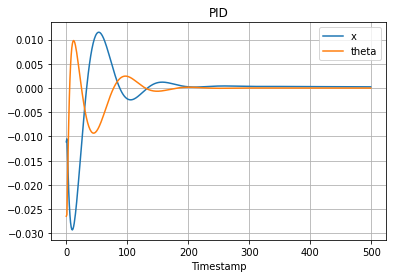

In [162]:
x, theta, N = PID_opt_fun_withX(500, 0.4, 100, 0.5, 1, 1)
plot_result(x, theta, N)

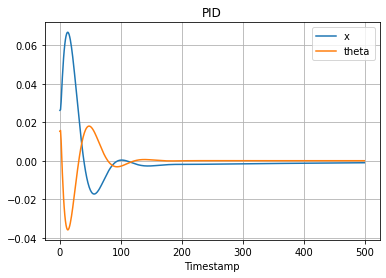

In [166]:
x, theta, N = PID_opt_fun_withX(400, 0.4, 100, 0.5, 1, 1)
plot_result(x, theta, N)

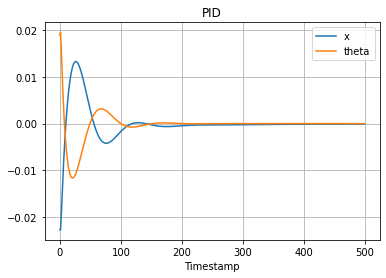

In [171]:
x, theta, N = PID_opt_fun_withX(400, 1, 90, 0.5, 1, 1)
plot_result(x, theta, N)

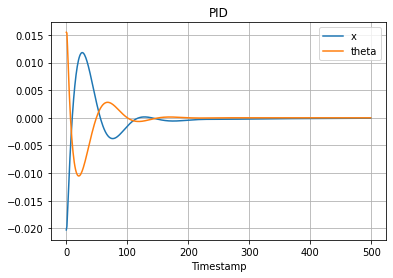

In [172]:
x, theta, N = PID_opt_fun_withX(400, 1, 90, 0.5, 1, 1)
plot_result(x, theta, N)

In [23]:
def PID_opt_fun_mean_fix(P, I, D):
    tau = 0.02
    N = 0 
    K = 0
    q = 100
    for attempt in range(q):
        state = env.reset()
        integral = 0
        derivative = 0
        prev_error = 0
        for t in range(100):
            #env.render()
            integral += state[2] * tau
            derivative = state[3]
            error = state[2]
            res = I * integral + D * derivative + P * error
            N+=abs(state[2])
            K+=abs(state[3])
            if res>0:
                action = 1
            else:
                action = 0

            state, reward, done, info = env.step(action)
    return N / q, K/q

In [ ]:
PID_opt_fun_mean_fix(1, 0, 1)

31.654419898028088


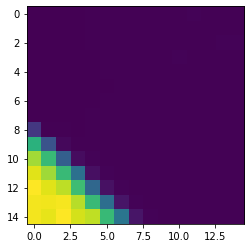

In [28]:
OPT_arr = []
x_i = 0.25
Min = 100
xx_i = 0
xx_d = 0
for i in range(15):
    I = []
    x_d = 0.25
    for d in range(15):
        th, thh = PID_opt_fun_mean_fix(1, x_i, x_d)
        r = 30*th + thh
        I.append(r)
        if r<Min:
            Min = r
            xx_i = x_i
            xx_d = x_d
        x_d *= 2
    OPT_arr.append(I)
    x_i *= 2
plt.imshow(OPT_arr)
print(min(min(OPT_arr)))

In [25]:
print(min(min(OPT_arr)))

27.58468297844959


In [26]:
xx_i, xx_d

(0.002, 0.064)

76.41756996131666
2.0 0.25


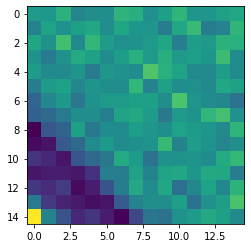

In [30]:
OPT_arr = []
x_i = 0.25
for i in range(15):
    I = []
    x_d = 65
    for d in range(15):
        th, thh = PID_opt_fun_mean_fix(1, x_i, x_d)
        r = 30*th + thh
        I.append(r)
        if r<Min:
            Min = r
            xx_i = x_i
            xx_d = x_d
        x_d *= 2
    OPT_arr.append(I)
    x_i *= 2
plt.imshow(OPT_arr)
print(min(min(OPT_arr)))
print(xx_i, xx_d)

In [89]:
def PID_opt_fun_mean(P, I, D):
    tau = 0.02
    N = 0 # number of attempt
    q = 100
    for attempt in range(q):
        state = env.reset()
        integral = 0
        derivative = 0
        prev_error = 0
        n = 200
        for t in range(200):
            #env.render()
            integral += state[2] * tau
            derivative = state[3]
            error = state[2]
            res = I * integral + D * derivative + P * error
            if res>0:
                action = 1
            else:
                action = 0

            state, reward, done, info = env.step(action)
            if done or abs(state[0]) > 0.10:
                N += t
                break
    return N // q

In [145]:
OPT_arr = []
x_i = 0.01
for i in range(20):
    I = []
    x_d = 0.01
    for d in range(20):
        I.append(PID_opt_fun_mean(1, x_i, x_d))
        x_d *= 2
    OPT_arr.append(I)
    x_i *= 2
plt.imshow(OPT_arr)

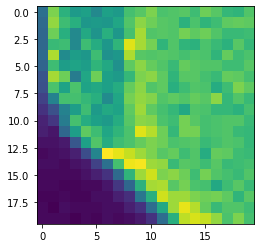

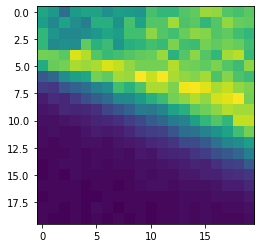

In [151]:
OPT_arr1 = []
x_i = 0.01*1024
for i in range(20):
    I = []
    x_d = 0.01*32
    for d in range(20):
        I.append(PID_opt_fun_mean(1, x_i, x_d))
        x_d *= 1.2
    OPT_arr1.append(I)
    x_i *= 1.5
plt.imshow(OPT_arr1)

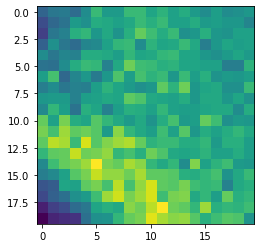

In [153]:
OPT_arr2 = []
x_i = 0.01*1024
for i in range(20):
    I = []
    x_d = 0.01*32*3
    for d in range(20):
        I.append(PID_opt_fun_mean(1, x_i, x_d))
        x_d *= 1.2
    OPT_arr2.append(I)
    x_i *= 1.2
plt.imshow(OPT_arr2)

In [157]:
max(max(OPT_arr2))

89

In [158]:
max(max(OPT_arr1))

89

In [159]:
max(max(OPT_arr))

83

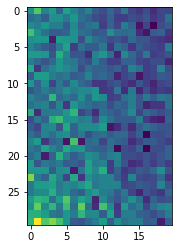

In [160]:
OPT_arr3 = []
x_i = 0.01*1024
for i in range(30):
    I = []
    x_d = 0.01*32*3*4
    for d in range(20):
        I.append(PID_opt_fun_mean(1, x_i, x_d))
        x_d *= 1.15
    OPT_arr3.append(I)
    x_i *= 1.1
plt.imshow(OPT_arr3)

In [163]:
max(max(OPT_arr3))

99

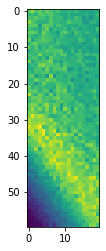

In [162]:
for i in range(30):
    I = []
    x_d = 0.01*32*3*3
    for d in range(20):
        I.append(PID_opt_fun_mean(1, x_i, x_d))
        x_d *= 1.15
    OPT_arr3.append(I)
    x_i *= 1.1
plt.imshow(OPT_arr3)

93


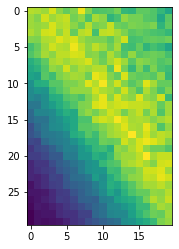

In [164]:
OPT_arr4 = []
x_i = 170
Max = 0
xx_i = 0
xx_d = 0
for i in range(30):
    I = []
    x_d = 3
    for d in range(20):
        n = PID_opt_fun_mean(1, x_i, x_d)
        I.append(n)
        if n>Max:
            Max = n
            xx_i = x_i
            xx_d = x_d
        x_d *= 1.15
    OPT_arr4.append(I)
    x_i *= 1.1
plt.imshow(OPT_arr4)
print(max(max(OPT_arr4)))

94


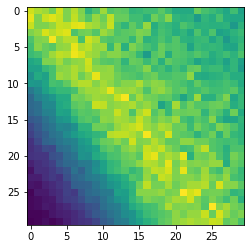

In [168]:
OPT_arr5 = []
x_i = 150
for i in range(30):
    I = []
    x_d = 2.5
    for d in range(30):
        n = PID_opt_fun_mean(1, x_i, x_d)
        I.append(n)
        if n>Max:
            Max = n
            xx_i = x_i
            xx_d = x_d
        x_d *= 1.15
    OPT_arr5.append(I)
    x_i *= 1.1
plt.imshow(OPT_arr5)
print(max(max(OPT_arr5)))

In [169]:
Max

98

In [170]:
xx_d, xx_i

(2.875, 150)

92


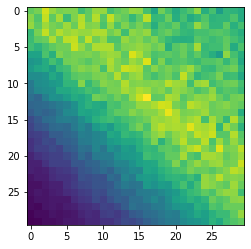

In [171]:
OPT_arr6 = []
x_i = 150
for i in range(30):
    I = []
    x_d = 2.3
    for d in range(30):
        n = PID_opt_fun_mean(1, x_i, x_d)
        I.append(n)
        if n>Max:
            Max = n
            xx_i = x_i
            xx_d = x_d
        x_d *= 1.1
    OPT_arr6.append(I)
    x_i *= 1.1
plt.imshow(OPT_arr6)
print(max(max(OPT_arr6)))

In [135]:
OPT_arr1 = []
for p in range(10):
    P = []
    for i in range(10):
        I = []
        for d in range(10):
            I.append(PID_opt_fun_mean(p/10, i, d))
        P.append(I)
    OPT_arr1.append(P)

In [86]:
OPT_arr1

[[[8, 114, 114, 118, 114, 108, 115, 109, 111, 114],
  [17, 97, 116, 122, 119, 113, 112, 118, 114, 109],
  [16, 50, 97, 115, 115, 111, 123, 125, 117, 117],
  [15, 16, 71, 96, 105, 110, 127, 118, 114, 115],
  [16, 10, 41, 95, 102, 95, 105, 121, 103, 121],
  [17, 7, 21, 65, 84, 108, 117, 107, 105, 110],
  [16, 10, 15, 45, 77, 78, 90, 106, 117, 117],
  [16, 1, 10, 35, 73, 79, 97, 82, 105, 108],
  [17, 1, 3, 19, 44, 65, 84, 89, 96, 103],
  [16, 0, 8, 17, 31, 56, 68, 83, 79, 89]],
 [[41, 107, 118, 110, 116, 119, 104, 118, 112, 116],
  [22, 82, 108, 107, 115, 115, 110, 116, 117, 116],
  [20, 26, 87, 110, 114, 115, 116, 115, 105, 114],
  [19, 7, 61, 83, 101, 106, 107, 115, 117, 112],
  [18, 0, 35, 66, 83, 106, 105, 116, 113, 116],
  [17, 5, 19, 60, 74, 87, 105, 114, 111, 116],
  [18, 5, 5, 35, 55, 83, 94, 105, 109, 112],
  [17, 1, 5, 35, 56, 71, 79, 98, 98, 104],
  [18, 0, 9, 14, 39, 57, 78, 81, 95, 109],
  [17, 1, 8, 8, 20, 59, 59, 73, 85, 102]],
 [[41, 101, 109, 110, 111, 108, 110, 111, 114,

In [87]:
OPT_arr2 = []
for p in range(10):
    P = []
    for i in range(10):
        I = []
        for d in range(10):
            I.append(PID_opt_fun_mean(p/10, i, d*10))
        P.append(I)
    OPT_arr2.append(P)

In [88]:
OPT_arr2

[[[8, 109, 115, 108, 107, 111, 108, 115, 113, 106],
  [15, 113, 113, 107, 116, 120, 115, 119, 115, 105],
  [16, 113, 123, 119, 114, 112, 111, 120, 112, 116],
  [16, 112, 116, 113, 111, 111, 114, 113, 119, 118],
  [16, 118, 113, 112, 114, 117, 112, 112, 113, 111],
  [16, 119, 118, 118, 116, 114, 114, 110, 124, 118],
  [17, 110, 115, 114, 109, 122, 118, 116, 116, 112],
  [16, 115, 107, 110, 117, 116, 115, 118, 112, 119],
  [15, 102, 116, 117, 118, 120, 122, 110, 113, 115],
  [16, 103, 114, 113, 109, 115, 115, 109, 115, 110]],
 [[40, 110, 112, 112, 115, 117, 117, 114, 115, 114],
  [22, 118, 115, 114, 112, 117, 119, 117, 116, 113],
  [20, 115, 113, 115, 114, 121, 104, 109, 117, 110],
  [19, 117, 113, 109, 116, 109, 118, 107, 109, 112],
  [18, 114, 120, 110, 112, 113, 114, 107, 110, 107],
  [18, 114, 114, 106, 115, 114, 119, 111, 114, 116],
  [18, 115, 114, 117, 112, 114, 123, 108, 113, 112],
  [17, 119, 116, 119, 113, 127, 116, 113, 108, 113],
  [17, 107, 122, 124, 121, 112, 112, 123, 117,

In [90]:
OPT_arr3 = []
for p in range(10):
    P = []
    for i in range(10):
        I = []
        for d in range(10):
            I.append(PID_opt_fun_mean(p/10, i, d*10))
        P.append(I)
    OPT_arr3.append(P)

In [91]:
OPT_arr3

[[[7, 70, 59, 57, 68, 64, 67, 65, 67, 68],
  [9, 65, 63, 63, 66, 68, 70, 62, 65, 70],
  [10, 62, 67, 66, 61, 69, 68, 68, 65, 67],
  [10, 70, 70, 61, 69, 67, 62, 67, 69, 61],
  [9, 64, 62, 68, 64, 74, 59, 61, 63, 61],
  [10, 65, 66, 65, 63, 65, 63, 70, 61, 73],
  [10, 61, 60, 60, 68, 63, 77, 69, 65, 64],
  [9, 67, 62, 66, 65, 66, 66, 68, 68, 70],
  [10, 63, 68, 72, 66, 63, 62, 69, 66, 60],
  [9, 67, 66, 66, 60, 66, 67, 72, 68, 63]],
 [[21, 70, 61, 66, 63, 66, 62, 63, 72, 63],
  [14, 65, 71, 58, 68, 70, 66, 72, 67, 63],
  [12, 60, 64, 73, 65, 64, 62, 69, 64, 66],
  [12, 62, 61, 65, 66, 66, 63, 64, 66, 66],
  [10, 63, 63, 66, 70, 65, 71, 63, 68, 68],
  [11, 65, 62, 67, 70, 68, 63, 67, 62, 66],
  [11, 65, 67, 64, 65, 67, 60, 65, 59, 67],
  [10, 70, 65, 61, 64, 67, 67, 66, 66, 59],
  [11, 68, 72, 68, 70, 65, 65, 66, 61, 62],
  [10, 65, 67, 63, 73, 62, 62, 64, 65, 70]],
 [[21, 67, 71, 61, 68, 66, 60, 63, 63, 66],
  [15, 63, 67, 68, 66, 69, 62, 70, 64, 63],
  [13, 66, 72, 67, 63, 63, 62, 68, 

In [92]:
OPT_arr4 = []
for p in range(10):
    P = []
    for i in range(10):
        I = []
        for d in range(10):
            I.append(PID_opt_fun_mean(p/10, i/10, d*10))
        P.append(I)
    OPT_arr4.append(P)

In [93]:
OPT_arr4

[[[6, 62, 67, 62, 67, 63, 65, 65, 69, 66],
  [10, 66, 59, 64, 67, 68, 62, 71, 64, 65],
  [9, 69, 62, 65, 68, 67, 74, 66, 67, 64],
  [9, 64, 63, 64, 62, 64, 63, 62, 60, 64],
  [10, 66, 70, 65, 66, 66, 62, 64, 65, 67],
  [10, 67, 66, 58, 62, 64, 64, 59, 59, 69],
  [9, 67, 62, 64, 68, 60, 63, 70, 66, 66],
  [10, 64, 68, 64, 69, 59, 65, 65, 60, 67],
  [10, 65, 72, 66, 61, 63, 66, 65, 64, 65],
  [10, 68, 72, 68, 65, 64, 62, 64, 68, 62]],
 [[20, 66, 67, 62, 67, 70, 63, 64, 72, 65],
  [19, 69, 70, 67, 69, 61, 70, 64, 58, 61],
  [16, 69, 66, 72, 68, 64, 66, 63, 65, 67],
  [16, 72, 66, 70, 68, 65, 66, 67, 66, 66],
  [16, 65, 64, 65, 67, 65, 64, 65, 63, 67],
  [16, 62, 64, 61, 64, 68, 64, 62, 70, 64],
  [14, 64, 70, 64, 68, 66, 65, 66, 62, 68],
  [14, 68, 66, 63, 67, 63, 65, 67, 65, 69],
  [14, 62, 63, 58, 66, 60, 66, 70, 66, 62],
  [13, 68, 59, 71, 63, 59, 64, 67, 66, 67]],
 [[19, 68, 65, 65, 65, 64, 64, 65, 69, 67],
  [20, 65, 70, 67, 64, 66, 63, 66, 66, 66],
  [19, 65, 63, 62, 72, 68, 65, 66,

In [94]:
OPT_arr5 = []
for p in range(10):
    P = []
    for i in range(10):
        I = []
        for d in range(10):
            I.append(PID_opt_fun_mean(p/10, i*10, d*10))
        P.append(I)
    OPT_arr5.append(P)

In [95]:
OPT_arr5

[[[7, 64, 62, 64, 64, 62, 64, 65, 67, 66],
  [10, 69, 62, 64, 68, 65, 67, 69, 66, 66],
  [11, 67, 66, 74, 67, 71, 67, 65, 69, 67],
  [10, 75, 80, 64, 63, 59, 62, 63, 65, 63],
  [9, 68, 70, 67, 61, 64, 65, 68, 72, 68],
  [10, 68, 75, 69, 65, 67, 64, 69, 68, 67],
  [9, 70, 63, 65, 63, 67, 70, 64, 71, 66],
  [10, 69, 65, 67, 68, 62, 67, 66, 68, 64],
  [10, 73, 73, 65, 69, 69, 71, 66, 65, 62],
  [10, 73, 60, 74, 69, 63, 68, 67, 62, 67]],
 [[21, 58, 64, 69, 63, 70, 68, 66, 64, 64],
  [10, 69, 63, 65, 66, 62, 65, 64, 70, 67],
  [10, 66, 69, 70, 69, 67, 70, 64, 67, 66],
  [10, 76, 64, 66, 62, 58, 70, 57, 63, 66],
  [10, 68, 67, 62, 69, 65, 62, 69, 64, 68],
  [10, 71, 63, 66, 63, 66, 68, 65, 67, 70],
  [9, 72, 70, 64, 72, 71, 65, 68, 68, 65],
  [10, 68, 66, 63, 69, 67, 66, 64, 65, 68],
  [9, 58, 75, 68, 66, 65, 62, 66, 67, 68],
  [9, 72, 65, 68, 68, 75, 67, 61, 68, 67]],
 [[21, 67, 58, 67, 66, 62, 65, 67, 58, 66],
  [11, 68, 67, 64, 70, 62, 61, 66, 70, 72],
  [11, 66, 65, 64, 62, 65, 70, 60, 6

In [96]:
OPT_arr6 = []
for p in range(10):
    P = []
    for i in range(10):
        I = []
        for d in range(10):
            I.append(PID_opt_fun_mean(p/10, i*100, d*10))
        P.append(I)
    OPT_arr6.append(P)

In [97]:
OPT_arr6

[[[6, 65, 62, 67, 67, 71, 60, 69, 63, 72],
  [9, 75, 66, 72, 67, 69, 62, 66, 67, 70],
  [10, 74, 77, 75, 72, 72, 67, 71, 77, 69],
  [9, 80, 78, 72, 77, 77, 67, 63, 72, 62],
  [10, 73, 99, 78, 70, 82, 64, 71, 72, 70],
  [9, 78, 84, 79, 74, 73, 77, 65, 69, 77],
  [10, 86, 80, 74, 78, 81, 76, 76, 75, 74],
  [10, 76, 88, 83, 89, 84, 83, 76, 79, 71],
  [10, 67, 90, 83, 81, 83, 72, 73, 77, 72],
  [9, 73, 83, 84, 91, 85, 78, 77, 73, 75]],
 [[20, 64, 68, 65, 65, 63, 69, 67, 63, 68],
  [9, 74, 74, 69, 74, 67, 70, 73, 61, 70],
  [10, 74, 74, 75, 72, 68, 65, 71, 65, 66],
  [10, 82, 79, 78, 77, 70, 69, 70, 69, 68],
  [10, 96, 83, 74, 80, 75, 70, 64, 79, 70],
  [10, 90, 77, 81, 74, 78, 75, 67, 75, 74],
  [10, 84, 80, 72, 70, 78, 71, 76, 67, 74],
  [10, 74, 79, 88, 86, 78, 75, 74, 70, 72],
  [9, 69, 84, 85, 82, 65, 78, 73, 79, 78],
  [10, 71, 85, 79, 81, 78, 88, 82, 80, 83]],
 [[22, 64, 62, 69, 65, 62, 61, 67, 74, 62],
  [9, 68, 66, 72, 65, 72, 67, 69, 70, 68],
  [9, 79, 77, 75, 67, 74, 69, 67, 67, 

In [98]:
OPT_arr7 = []
for p in range(10):
    P = []
    for i in range(10):
        I = []
        for d in range(10):
            I.append(PID_opt_fun_mean(p, i*100, d*10))
        P.append(I)
    OPT_arr7.append(P)

In [99]:
OPT_arr7

[[[6, 63, 66, 67, 64, 63, 67, 67, 68, 67],
  [10, 76, 73, 64, 72, 71, 62, 67, 67, 66],
  [10, 81, 76, 75, 67, 67, 71, 68, 68, 73],
  [9, 82, 80, 73, 70, 72, 68, 65, 71, 71],
  [10, 86, 87, 78, 71, 73, 71, 75, 74, 68],
  [9, 84, 72, 79, 78, 69, 77, 69, 69, 77],
  [10, 85, 78, 81, 82, 72, 85, 79, 75, 71],
  [9, 71, 95, 86, 72, 73, 71, 69, 86, 78],
  [9, 70, 90, 92, 79, 71, 78, 77, 66, 79],
  [10, 64, 84, 89, 84, 80, 84, 75, 76, 73]],
 [[21, 75, 68, 65, 74, 65, 69, 60, 73, 68],
  [10, 81, 69, 70, 68, 71, 63, 70, 63, 68],
  [10, 77, 72, 68, 74, 68, 70, 69, 62, 77],
  [9, 81, 73, 77, 65, 80, 78, 72, 67, 71],
  [9, 90, 65, 68, 69, 80, 65, 71, 68, 72],
  [9, 89, 79, 79, 74, 86, 63, 67, 69, 66],
  [9, 85, 87, 81, 71, 78, 82, 77, 82, 67],
  [10, 75, 84, 84, 79, 77, 75, 76, 76, 73],
  [9, 76, 89, 81, 86, 83, 77, 81, 73, 76],
  [10, 60, 86, 80, 74, 78, 83, 70, 79, 84]],
 [[20, 77, 68, 64, 62, 74, 62, 67, 63, 68],
  [11, 76, 73, 70, 67, 75, 63, 70, 67, 66],
  [10, 82, 80, 75, 69, 80, 65, 70, 67, 6

In [100]:
OPT_arr8 = []
for p in range(10):
    P = []
    for i in range(10):
        I = []
        for d in range(10):
            I.append(PID_opt_fun_mean(10*p, i*100, d*10))
        P.append(I)
    OPT_arr8.append(P)

In [101]:
OPT_arr8

[[[6, 65, 64, 63, 64, 65, 64, 67, 69, 61],
  [10, 75, 77, 64, 67, 68, 67, 66, 69, 68],
  [10, 81, 78, 65, 64, 65, 65, 70, 64, 70],
  [11, 81, 75, 74, 68, 67, 66, 63, 66, 67],
  [10, 81, 83, 75, 78, 73, 82, 70, 68, 65],
  [9, 80, 70, 84, 79, 77, 77, 69, 73, 76],
  [9, 82, 81, 88, 72, 81, 65, 64, 73, 67],
  [10, 78, 88, 94, 87, 77, 71, 80, 69, 69],
  [10, 79, 81, 83, 74, 74, 80, 65, 81, 74],
  [10, 69, 86, 84, 85, 82, 77, 78, 74, 72]],
 [[20, 53, 68, 74, 77, 67, 74, 74, 76, 70],
  [15, 57, 74, 67, 70, 68, 70, 74, 76, 70],
  [11, 61, 54, 76, 90, 79, 77, 75, 74, 74],
  [10, 57, 72, 66, 71, 78, 75, 73, 72, 71],
  [10, 65, 70, 81, 71, 75, 63, 74, 81, 66],
  [11, 77, 65, 71, 80, 78, 80, 69, 73, 68],
  [10, 77, 64, 71, 78, 71, 64, 79, 71, 75],
  [11, 75, 85, 70, 72, 63, 75, 75, 70, 64],
  [10, 84, 86, 78, 73, 70, 75, 81, 66, 83],
  [10, 77, 88, 82, 78, 80, 76, 74, 70, 73]],
 [[19, 42, 50, 43, 71, 68, 74, 75, 79, 66],
  [14, 57, 54, 55, 75, 77, 70, 80, 74, 64],
  [12, 56, 56, 57, 67, 75, 76, 76

In [102]:
OPT_arr9 = []
for p in range(10):
    P = []
    for i in range(10):
        I = []
        for d in range(10):
            I.append(PID_opt_fun_mean(p, i*100, d))
        P.append(I)
    OPT_arr9.append(P)

In [103]:
OPT_arr9

[[[6, 64, 65, 67, 62, 68, 62, 60, 68, 70],
  [10, 69, 77, 86, 89, 71, 74, 75, 77, 80],
  [10, 40, 63, 81, 77, 76, 89, 87, 88, 81],
  [10, 33, 52, 66, 79, 86, 85, 96, 87, 87],
  [9, 26, 43, 55, 63, 71, 80, 80, 90, 83],
  [10, 20, 39, 50, 55, 63, 63, 70, 84, 80],
  [10, 18, 31, 44, 52, 60, 64, 71, 81, 76],
  [10, 17, 27, 39, 46, 53, 60, 64, 70, 70],
  [9, 16, 27, 32, 44, 51, 55, 55, 63, 71],
  [10, 13, 23, 28, 36, 48, 51, 54, 63, 68]],
 [[19, 66, 70, 71, 75, 71, 71, 71, 73, 67],
  [11, 82, 86, 79, 73, 84, 72, 80, 80, 68],
  [9, 49, 72, 85, 97, 88, 87, 78, 84, 74],
  [9, 32, 56, 74, 73, 81, 93, 85, 79, 83],
  [11, 23, 48, 57, 69, 74, 87, 87, 87, 88],
  [10, 22, 40, 55, 59, 68, 73, 75, 71, 81],
  [9, 18, 31, 45, 58, 64, 77, 71, 75, 75],
  [10, 17, 28, 38, 49, 53, 65, 76, 71, 73],
  [9, 18, 25, 36, 43, 55, 58, 59, 66, 70],
  [9, 15, 22, 33, 43, 44, 54, 58, 64, 67]],
 [[21, 47, 49, 52, 61, 68, 69, 79, 78, 72],
  [11, 58, 74, 67, 69, 65, 76, 61, 70, 67],
  [10, 55, 81, 78, 79, 78, 74, 85, 84,